## Biblioteki i dane

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ADFTest
from prophet import Prophet
import itertools
import statsmodels.api as sm
import pickle
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.stats import shapiro
from scipy.stats import jarque_bera

In [3]:
dfo = pd.read_csv('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/AEP_hourly.csv')
dfo['Datetime'] = pd.to_datetime(dfo['Datetime'])

## Wstęp

Celem projektu jest analiza oraz prognoza zużycia energii elektrycznej na podstawie danych zebranych przez PJM Interconnection LLC. Dane te obejmują godzinowe zużycie energii w różnych regionach USA. Zaczniemy od analizy danych pod względem występowania trendu oraz sezonowości. Nastepnie dobierzemy odpowiednie modele oraz wykonamy prognozy zużycia energii.

Celem biznesowym na który projekt ma odpowiadać jest minimalizacja ryzyka przepalenie się sieci przesyłowej. Może ono wystąpić gdy faktyczne zużycie energii jest mniejsze niż przywidywane i gdy nie ma gdzie tej energii wysłać (i.e. przy większych odchyleniach od przewidywać ryzyko to rośnie). Z tego powodu do błędu prognozy użyjemy metryk, które penalizują mocniej duże odchylenia oraz penalizują asymetrycznie.

## Wstępna analiza danych

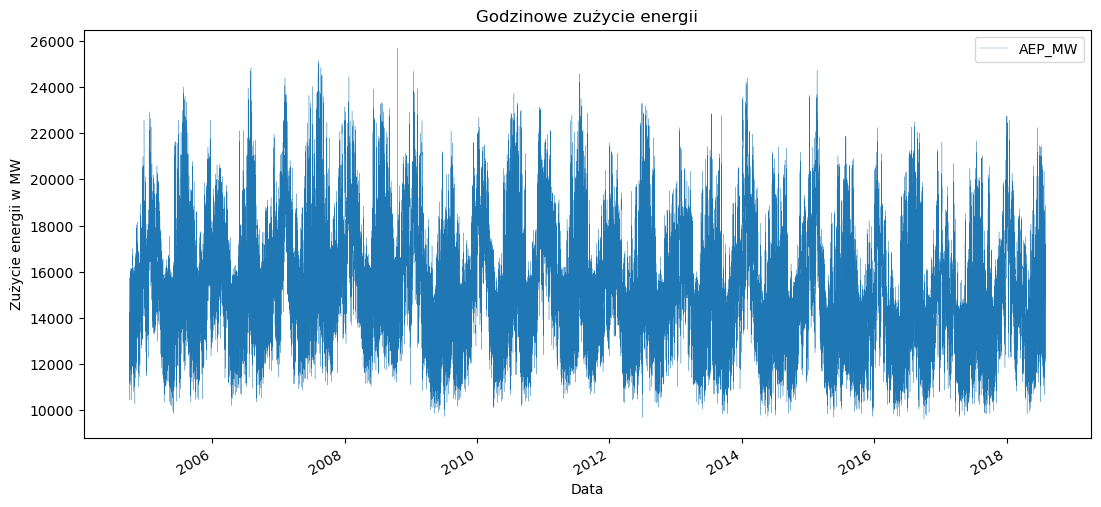

In [5]:
dfo.set_index('Datetime').plot(figsize = (13,6), linewidth=0.2, title = 'Godzinowe zużycie energii')
plt.xlabel('Data')
plt.ylabel('Zużycie energii w MW')
plt.show()

Zaczniemy od przyjrzenia się wykresowi danych godzinowych. Od razu widzimy, że w danych występuje sezonowość roczna. Trend nie jest zbyt wyraźny, średni poziom zużycia energii wydaje się raczej stały na przestrzeni lat. Z racji na dużą ilośc danych oraz to, że sezonowości są długoterminowe a dane są godzinowe przeprowadzimy agregację na dwa poziomy - dzienny i tygodniowy. Ułatwi to dobór odpowiednich modeli.

## Agregacja tygodniowa

In [7]:
df = dfo.groupby(pd.Grouper(key='Datetime', axis=0, freq='W')).sum()
df.sort_index(inplace = True)

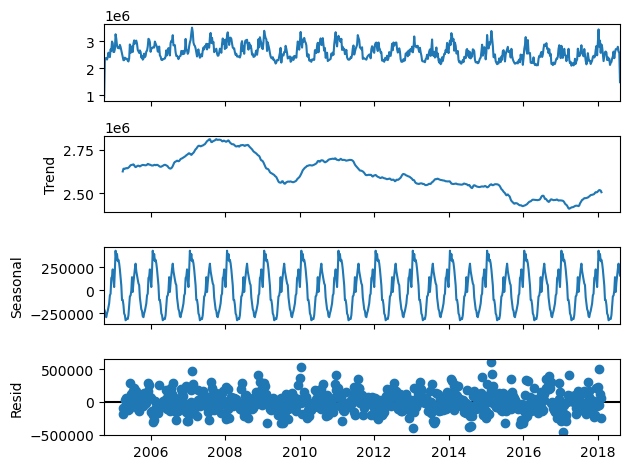

In [9]:
decomp_a = seasonal_decompose(df, model = 'additive', period = 52)
decomp_a.plot()
plt.show()

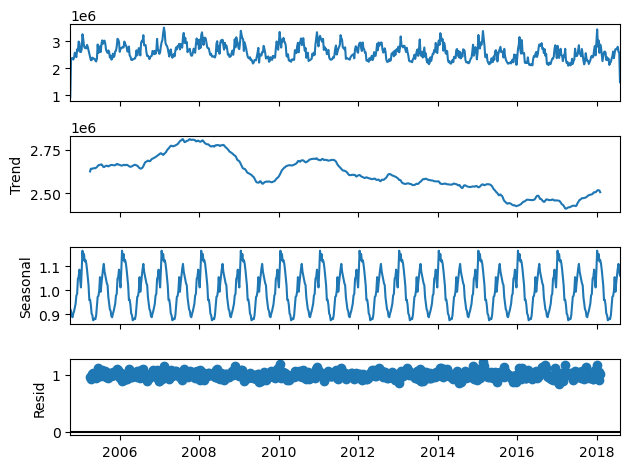

In [10]:
decomp_a = seasonal_decompose(df, model = 'multiplicative', period = 52)
decomp_a.plot()
plt.show()

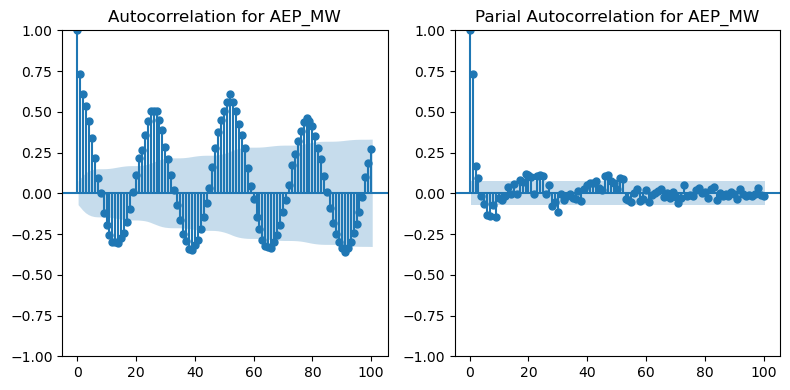

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_acf(df, lags=100, ax=axes[0])
axes[0].set_title("Autocorrelation for AEP_MW")

plot_pacf(df, lags=100, ax=axes[1])
axes[1].set_title("Parial Autocorrelation for AEP_MW")

plt.tight_layout()
plt.show()

Dekompozycja oraz wartości funkcji autokorelacji potwierdziły nasze przypuszczenia o mocnej sezonowości. ACF przyjmuje szczyty co około 13 opóźnień, co może sugerować sezonowość kwartalną. Dodatkowo wartości bardzo powoli zanikają, co może sugerować pewien trend. Funkcja cząstkowej autokorelacji przyjmuje największe wartości na pierwszym opóźnieniu, więc możliwe że w doborze odelu SARIMA nie będziemy potrzebowali zbyt dużych opóźnień.

Dalszą analizę będziemy przeprowadzać na danych oryginalnych oraz zlogarytmowanych, które następnie zrożnicujemy z krokami 1 oraz 52. Pomoże to wyeliminować (potencjalny) trend i niestacjonarność. Dodatkowo różnice logarytmów można interpretować jako stopy wzrostu w skali logarytmicznej (gdyby dane były finansowe to mówilibyśmy o stopie zwrotu przy kapitalizacji ciągłej). Dane po takiej transformacji mogą lepiej opisywać dynamikę (względne różnice) zużycia energii między kolejnymi okresami.

In [15]:
dfm = df.copy()
dfm['AEP_MW_ln'] = np.log(dfm['AEP_MW'])
dfd = dfm.diff(1).diff(52)
dfd = dfd.dropna()

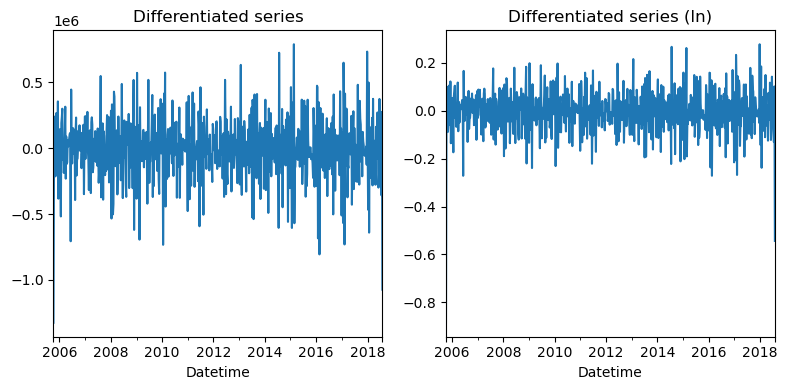

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

dfd['AEP_MW'].plot(ax=axes[0]) 
axes[0].set_title("Differentiated series")

dfd['AEP_MW_ln'].plot(ax=axes[1])
axes[1].set_title("Differentiated series (ln)")

plt.tight_layout()
plt.show()

Szereg po zróżnicowaniu o wiele bardziej przypomina szereg stacjonarny. Widzimy, że wartość oczekiwana jest stała oraz wydaje się, że wariancja jest niezmiennicza na przesunięcia. Przypuszczenie o stacjonarności potwierdzimy testem ADF, którego hipoteza zerowa mówi o występowaniu tzw. unit root'u - czyli inaczej H0: Szereg nie jest stacjonarny.

In [19]:
adt1, adt2 = adfuller(dfd['AEP_MW']), adfuller(dfd['AEP_MW_ln'])
print(f"p-value szeregu {adt1[1]}, p-value szeregu ln {adt2[1]}")

p-value szeregu 3.6978756890071637e-23, p-value szeregu ln 1.8725339365726934e-22


P-value obydwu szeregów jest praktycznie zerowe, co potwierdza nasze przypuszczenia - szeregi po transformacji są stacjonarne. Następnie sprawdzimy autokorelacje.

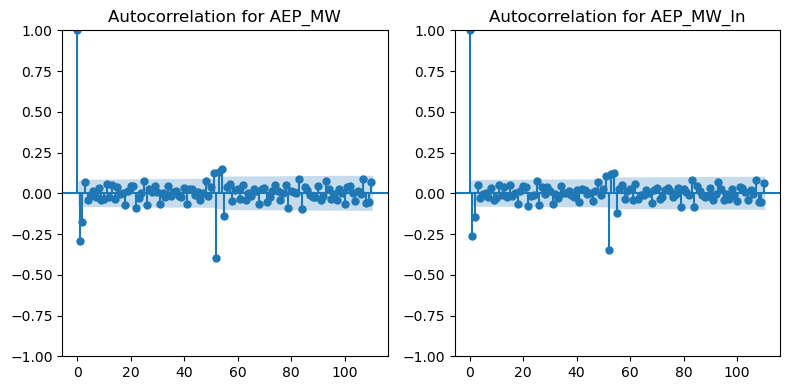

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_acf(dfd['AEP_MW'], lags=110, ax=axes[0])
axes[0].set_title("Autocorrelation for AEP_MW")

plot_acf(dfd['AEP_MW_ln'], lags=110, ax=axes[1])
axes[1].set_title("Autocorrelation for AEP_MW_ln")

plt.tight_layout()
plt.show()

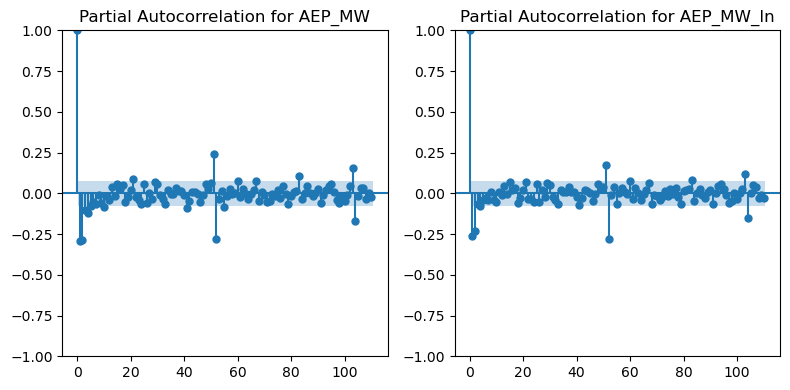

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_pacf(dfd['AEP_MW'], lags=110, ax=axes[0])
axes[0].set_title("Partial Autocorrelation for AEP_MW")

plot_pacf(dfd['AEP_MW_ln'], lags=110, ax=axes[1])
axes[1].set_title("Partial Autocorrelation for AEP_MW_ln")

plt.tight_layout()
plt.show()

Wartości ACF oraz PACF są największe dla opóźnieni 1, 2 oraz dla wielokrotności 52 i 53. Korzystając z tej informacji dobierzemy modele SARIMA z $p,q,P,Q = 1, 2$ oraz z $i, I = 1$. Dla każdego z nich policzymy AIC oraz BIC i do następnego etapu wybierzemy tylko modele z najmniejszymi wartościami kryteriów informacyjnych.

In [27]:
data_train = dfm.loc['2005-01-01':'2017-12-31', :]
data_test = dfm.loc['2018-01-01':'2018-06-30', :]

In [29]:
dfL = pd.read_pickle('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/AIC1.pkl')
dfL2 = pd.read_pickle('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/AIC2.pkl')

In [31]:
df_IC = pd.concat([dfL.loc[[dfL['AIC'].idxmin()]], dfL.loc[[dfL['BIC'].idxmin()]], dfL.loc[[dfL2['AIC'].idxmin()]], dfL.loc[[dfL2['AIC'].idxmin()]]])
df_IC.reset_index(drop = True, inplace= True)
df_IC.index = ['Dane oryginalne', 'Dane oryginalne', 'Logarytm', 'Logarytm']

In [33]:
df_IC

,p,q,P,Q,AIC,BIC
Dane oryginalne,0,2,0,2,16927.820099,16950.016851
Dane oryginalne,0,2,0,1,16929.476180,16947.233581
Logarytm,1,1,1,2,16945.164859,16971.800961
Logarytm,1,1,1,2,16945.164859,16971.800961


Widzimy, że dla danych zlogarytmowanych w obydwu kryteriach dostaliśmy ten sam model, natomiast w przypadku danych oryginalnych inny model miał najlepsze AIC a inny BIC. Przeanalizujemy teraz reszty tych modeli - sprawdzimy ich normalnośc oraz niezależność

In [76]:
with open('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/models.pkl', "rb") as f:
    models = pickle.load(f)

In [37]:
model_names = ['SARIMA(0,1,2,0,1,2,52)', 'SARIMA(0,1,2,0,1,1,52)', 'SARIMA(1,1,1,1,1,2,52) log']

In [67]:
resid_list = []
for i in range(3):
    model_fit = models[i]
    if i < 2:
        resid = model_fit.resid
    else: 
        resid = np.exp(model_fit.resid[1:])
    resid_list.append(resid)

SARIMA(0,1,2,0,1,2,52) 



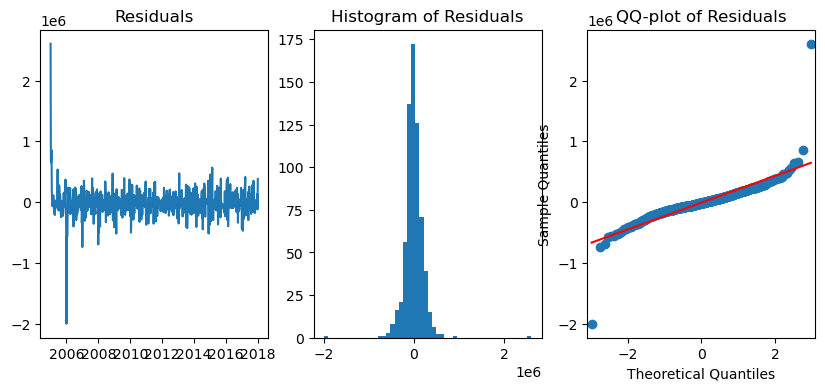

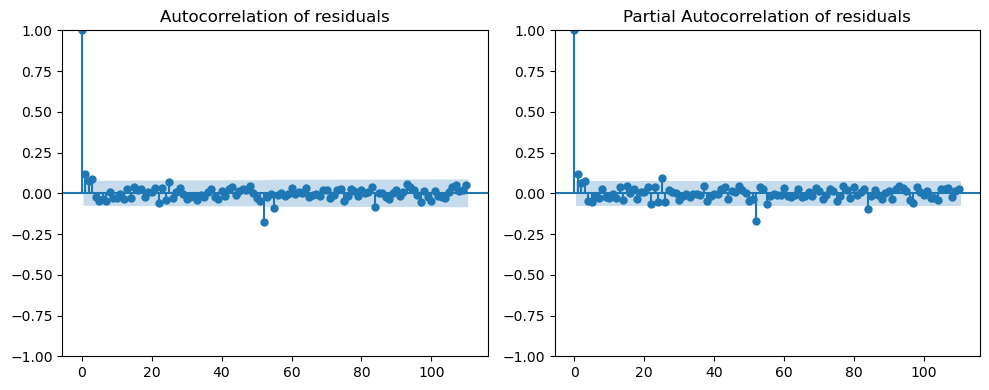

SARIMA(0,1,2,0,1,1,52) 



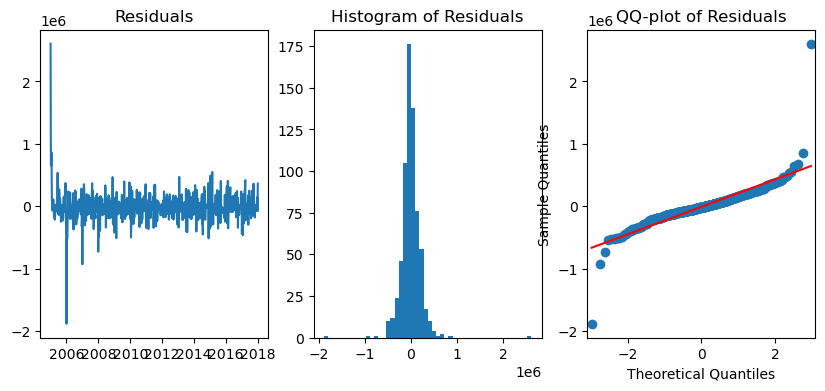

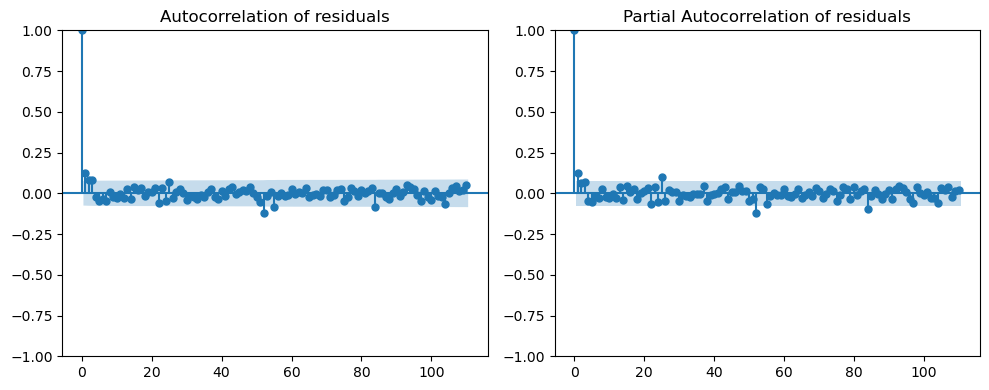

SARIMA(1,1,1,1,1,2,52) log 



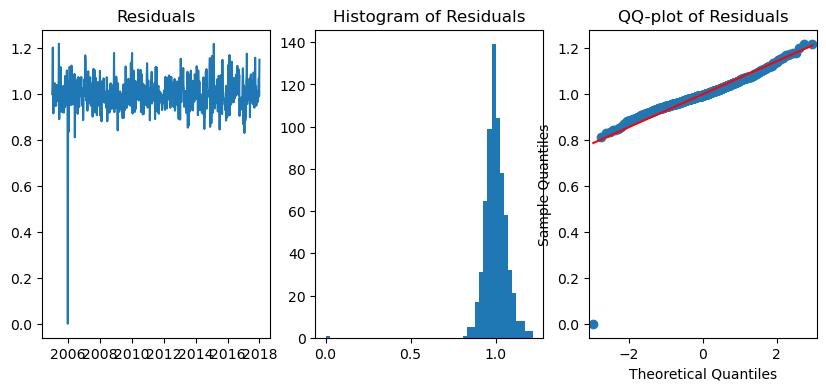

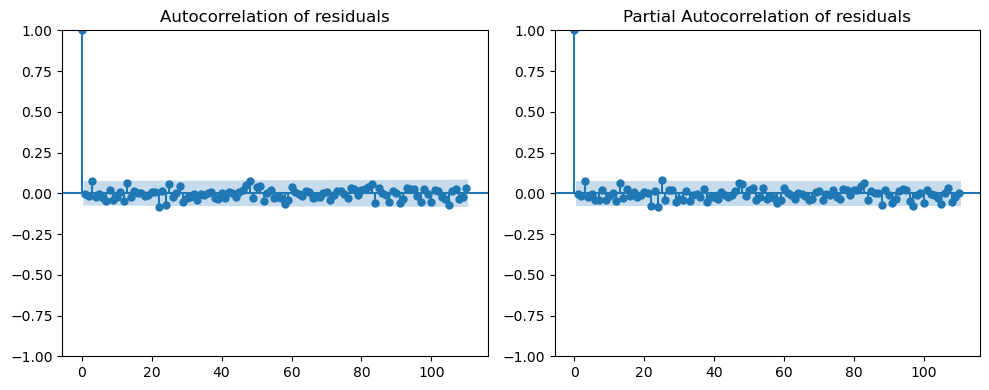

In [68]:
for i in range(3):

    print(f'{model_names[i]} \n')

    resid = resid_list[i]

    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    axes[0].plot(resid)
    axes[0].set_title("Residuals")

    axes[1].hist(resid, bins=50)
    axes[1].set_title("Histogram of Residuals")

    sm.qqplot(resid, line='s', ax=axes[2])
    axes[2].set_title("QQ-plot of Residuals")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    plot_acf(resid, lags=110, ax=axes[0])
    axes[0].set_title("Autocorrelation of residuals")

    plot_pacf(resid, lags=110, ax=axes[1])
    axes[1].set_title("Partial Autocorrelation of residuals")_

    plt.tight_layout()
    plt.show()

In [42]:
for i in range(3):
    resid = resid_list[i]
    stap, p = shapiro(resid)
    p2 = jarque_bera(resid)
    print(f'P value testu SW dla modelu {model_names[i]} wynosi {p} \n')
    print(f'P value testu JB dla modelu {model_names[i]} wynosi {p2[1]} \n')

P value testu SW dla modelu SARIMA(0,1,2,0,1,2,52) wynosi 8.129484147389657e-28 

P value testu JB dla modelu SARIMA(0,1,2,0,1,2,52) wynosi 0.0 

P value testu SW dla modelu SARIMA(0,1,2,0,1,1,52) wynosi 1.6287637687931463e-27 

P value testu JB dla modelu SARIMA(0,1,2,0,1,1,52) wynosi 0.0 

P value testu SW dla modelu SARIMA(1,1,1,1,1,2,52) log wynosi 1.8574209569984875e-27 

P value testu JB dla modelu SARIMA(1,1,1,1,1,2,52) log wynosi 0.0 



Wykresy mogłyby sugerować, że reszty mają rozkład normalny, natomiast testy Shapiro-Wilka oraz Jarque-Bera (ten drugi oparty jest na skośności i kurtozie) odrzucają hipoteze zerową, która mówi że dane pochodzą z rozkładu normalnego. Prawdopodobnie czynnikiem jest większa kurtoza, gdyż reszty wyglądają symetrycznie.

Co do autokorelacji w resztach, w modelach opartych na danych nieztransformowanych widzimy jeszcze istotne statystycznie wartości - szczególnie przy wielokrotnościach 52. W modelu opartych na logarytmach reszty są nieskorelowane. Sugeruje nam to, że ten ostatni model może być lepszy. 

Nastepnie rozważymy model Prophet, który będziemy traktować jako black-box. Pozwala on modelować sezonowości przy pomocy szeregów fouriera. Intepretacja parametrów (period, fourier order) jest następująca. Mamy rozwinięcie w szereg:

$s(t) = \sum_{n=1}^{k} \left( a_n \cos\left( \frac{2\pi n t}{T} \right) + b_n \sin\left( \frac{2\pi n t}{T} \right) \right)$

Gdzie $T$ to period a $k$ to fourier_order. Innymi słowy im większy fourier order tym więcej sinus i cosinus. Przyjmiemy $T = 1, 52$ oraz fourier_order $= 3, 5$.

In [78]:
with open('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/models_p.pkl', "rb") as f:
    models_p = pickle.load(f)

Na koniec, przeprowadzimy ręczną dekompozycje szeregu na trend i sezonowość, a na podstawie tego przeprowadzimy prognozy. Do wyznaczenia komponenty trendu użyjemy regresji wielomianowej stopnia 3 a sezonowość wyestyujemy jako średnią wartość szeregu z odjętym trendem w danym tygodniu.

In [142]:
df_ts = pd.read_pickle('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/df_ts.pkl')

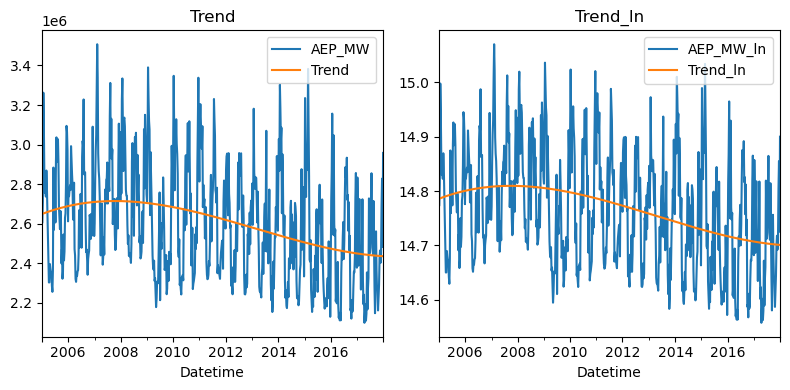

In [144]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

df_ts.loc[:, df_ts.columns[[0, 2]]].plot(ax=axes[0])
axes[0].set_title("Trend")

df_ts.loc[:, df_ts.columns[[1, 3]]].plot(ax=axes[1])
axes[1].set_title("Trend_ln")

plt.tight_layout()
plt.show()

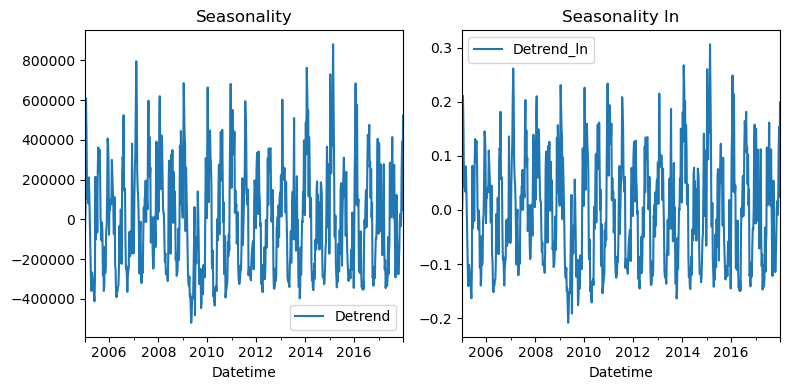

In [146]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

df_ts.loc[:, df_ts.columns[[4]]].plot(ax=axes[0])
axes[0].set_title("Seasonality")

df_ts.loc[:, df_ts.columns[[5]]].plot(ax=axes[1])
axes[1].set_title("Seasonality ln")

plt.tight_layout()
plt.show()

Mając już wybrane kilka modeli, które dopasowane zostały na zbiorze treningowym (dane do końca roku 2017) przeprowadzimy prognozy i policzymy błędy predykcji (na zbiorze testowym - pierwsze pół roku 2018). Metrykami, kórych użyjemy będą:

$L2 = \sum_n (| \hat{Y_n} - Y_n |^2)^{\frac{1}{2}}$,

$L2 = \sum_n (| \hat{Y_n} - Y_n |^3)^{\frac{1}{3}}$,

$AL2 = \sum_n (| w_n( \hat{Y_n} - Y_n) |^2)^{\frac{1}{2}}$,

$AL3 = \sum_n (| w_n(\hat{Y_n} - Y_n) |^3)^{\frac{1}{3}}$.

Gdzie $w_n = 1.1$ jeżeli $\hat{Y_n} - Y_n > 0$ i $w_n = 0.9$ w.p.p. Metryki te zostały wybrane ponieważ penalizują większe odchylenia mocniej (szczególnie te z $p = 3$) a ostatnie dwie metryki dodatkowo mocniej penalizują przeszacowaina prognozy.

In [251]:
df_pred = pd.read_pickle('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/df_pred.pkl')

In [253]:
df_pred.columns = ['Wartość prawdziwa', 'SARIMA 1', 'SARIMA 2', 'SARIMA log', 'Prophet', 'Prophet log', 'Regresja i sezonowość', 'Regresja i sezonowość log']

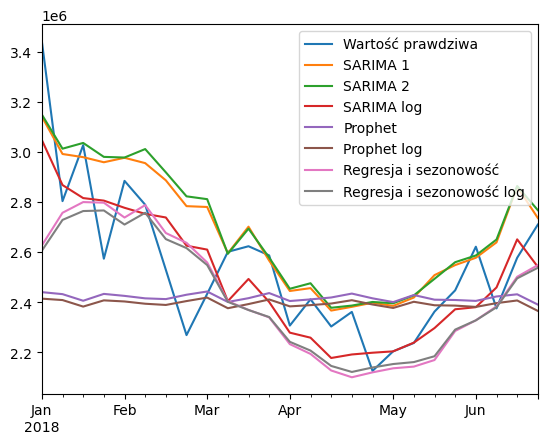

In [255]:
df_pred.plot()
plt.show()

Na wykresie wydaje się, że model SARIMA zbudowany na danych zlogarytmowanych najlepiej prognozuje prawdziwe wartości. Potwierdzimy to porównując w.w. metryki

In [265]:
df_err = pd.read_pickle('C:/Users/Admin/OneDrive/Pulpit/studia/III sem/Szeregi Czasowe/Projekt/df_err.pkl')
df_err.index = df_pred.columns[1:]

In [267]:
df_err

,L2,L3,AL2,AL3
SARIMA 1,1087033.150815,737583.826561,1179715.177865,802903.583109
SARIMA 2,1154087.609588,784883.127264,1255718.236227,856562.108433
SARIMA log,864355.296006,577523.643279,846349.463371,569912.805489
Prophet,1551437.403957,1160285.04121,1427201.240137,1052694.006581
Prophet log,1603648.243575,1197454.605692,1465737.391883,1083232.141682
Regresja i sezonowość,1214643.156243,904120.880231,1133261.70776,833336.662269
Regresja i sezonowość log,1213883.757495,915935.490263,1126081.595026,839551.224667


Faktycznie, model logarytmiczny ma najmniejsze błędy prognozy względem wszystkich metryk. Prawdopodobnie poradził sobie lepiej od innych z racji na lepsze uchwycenie dynamiki zmian między okresami. Kolejnym najlepszym modelem jest SARIMA zbudowana na danych niezlogarytmowanych z parametrami $(0, 1, 2, 0, 1, 2, 52)$